In [1]:
#ライブラリをインポート
import os #OSに依存する様々な機能を利用するためのモジュール(ファイルやディレクトリ操作など)
import re #正規表現を利用するためのモジュール
import csv  #csvファイルを扱うためのモジュール
import math #数学的計算のためのモジュール
import matplotlib.pyplot as plt #グラフ描画のためのモジュール
import numpy as np  #多次元配列計算のためのモジュール
import pandas as pd #データフレームを扱うためのモジュール
from scipy.stats import skew, kurtosis  #歪度と尖度を調べるためのモジュール
from sklearn.model_selection import train_test_split  #データをトレーニング用とテスト用に分けるためのモジュール
from sklearn import preprocessing #データを正規化するためのモジュール
from sklearn.preprocessing import StandardScaler  #データを標準化するためのモジュール
from sklearn.linear_model import LinearRegression #線型回帰
from sklearn.svm import SVC #サポートベクターマシン
from sklearn.ensemble import RandomForestClassifier #ランダムフォレスト
from sklearn.neighbors import KNeighborsClassifier  #k-近傍法
from sklearn.metrics import accuracy_score  #機械学習モデルの性能評価のためのモジュール

In [2]:
#定数を定義
BINS = 4000  #ヒストグラムのビンの数
EPSILON = .00001  #スムージングパラメータ
UPPER_LIMIT = 1.1 #静止区間の上限
LOWER_LIMIT = 0.9 #静止区間の加減
STATIONARY_INTERVALS = 5  #静止区間除去のサンプルの間隔(静止区間が何サンプル連続したら除去するか)
TRAIN_SIZE = 0.8  #ランダムフォレストのトレーニングデータの割合
N_ESTIMATORS = 100

In [3]:
#ディレクトリ内のデータセットのファイル名と周波数を取得する関数
def get_Hz_and_filename(path: str) -> list[int, str]:
    filename = os.listdir(path) #引数のパスのディレクトリの中のファイル名一覧を取得
    Hz_and_filename=[]  #ファイル名と周波数を格納するリストを宣言

    for file in filename:
        Hz = re.search(r'\d+', file)    #正規表現を用いてファイル名の中で一番最初に出てくる数字(周波数)を取得
        if Hz:  #数字の入っていないファイル名があるとエラーを吐くので、このif文でチェックする
            Hz_and_filename.append([int(Hz.group(0)), file])    #ファイル名と周波数を格納

    return Hz_and_filename

In [4]:
#ファイル名と周波数を分けて出力する関数
def divide_Hz_and_filename(Hz_and_filename: list[int, str]) -> tuple[list[int], list[str]]:
    Hz = []
    filename = []
    for row in Hz_and_filename:
      Hz.append(row[0])
      filename.append(row[1])

    return Hz, filename

In [5]:
#加速度データのCSVファイルから3軸加速度を取得する関数
def get_acceleration(filename: str) -> tuple[list[float], list[float], list[float]]:
    AccX, AccY, AccZ = [], [], []
    with open(filename) as f:
        reader = csv.reader(f)
        for row in reader:
            AccX.append(float(row[2]))
            AccY.append(float(row[3]))
            AccZ.append(float(row[4]))

    return AccX, AccY, AccZ

In [6]:
#静止区間を除去する関数
def remove_stationary_intervals(AccX: list[float], AccY: list[float], AccZ: list[float]) -> list[float]:
    #各軸の加速度の平均を求める
    AvgAccX = sum(AccX) / len(AccX)
    AvgAccY = sum(AccY) / len(AccY)
    AvgAccZ = sum(AccZ) / len(AccZ)

    AvgResultantAcc = math.sqrt(AvgAccX ** 2 + AvgAccY ** 2 + AvgAccZ ** 2) #重力加速度の推定値=合成加速度の平均を求める

    ResultantAcc = [math.sqrt(x ** 2 + y ** 2 + z ** 2) for x, y, z in zip(AccX, AccY, AccZ)]   #各時刻の合成加速度を求める

    #各時刻の合成加速度から静止区間(重力加速度の推定値に近い値が一定以上以上連続している区間)を除去する
    i = 0 #ループ変数
    counter = 0 #静止区間がSTATIONARY_INTERVALS分続いているかをカウントする変数
    while i < len(ResultantAcc):
        if AvgResultantAcc * LOWER_LIMIT < ResultantAcc[i] < AvgResultantAcc * UPPER_LIMIT:   #平均のLOWER_LIMIT倍~UPPER_LIMIT倍の範囲を調べる
            counter += 1    #範囲内ならカウントを増やす
            if counter == STATIONARY_INTERVALS: #カウントがSTATIONARY_INTERVALSに達したらその区間を削除
                del ResultantAcc[i+1-STATIONARY_INTERVALS:i+1]    #スライスでは選択範囲の開始位置startと終了位置stopを[start:stop]のように書くとstart <= x < stopの範囲が選択される #start番目の値は含まれるがstop番目の値は含まれない
                counter = 0 #カウンターをリセット
                i -= STATIONARY_INTERVALS   #削除した分インデックスがズレるので補正する
        else:
            counter = 0 #カウンターをリセット
        i += 1

    return ResultantAcc  #静止区間を除去した後のリストを返す

In [7]:
#連続する2サンプルの差分を取る関数
def calculate_differences_of_acceleration(ResultantAcc: list[float]) -> list[float]:
    DifferenceAcc = [math.fabs(ResultantAcc[i + 1] * 100000 - ResultantAcc[i] * 100000) for i in range(len(ResultantAcc) - 1)]  #100000倍して誤差を取る
    return DifferenceAcc

In [8]:
#KLダイバージェンス関数 #引数として与える2つの分布は非負の値の集合でなければならないことに注意
def KL_divergence(a: list[float], b: list[float]) -> float:
    min_value = min(min(a), min(b)) #a,bの最小値の小さい方
    max_value = max(max(a), max(b)) #a,bの最大値の大きい方

    #a,bのヒストグラムを作成し、同じ数のビンで区切る
    a_hist, _ = np.histogram(a, bins=BINS, range=(min_value, max_value))
    b_hist, _ = np.histogram(b, bins=BINS, range=(min_value, max_value))

    #正規化する(確率分布に変換する、合計を1にする)ために全合計で割る
    a_hist = (a_hist + EPSILON) / a_hist.sum()
    b_hist = (b_hist + EPSILON) / b_hist.sum()

    #KLダイバージェンスの値を返す
    return np.sum([ai * np.log(ai / bi) for ai, bi in zip(a_hist, b_hist)])

In [9]:
#JSダイバージェンス関数 #引数として与える2つの分布は非負の値の集合でなければならないことに注意
def JS_divergence(a: list[float], b: list[float]) -> float:
    min_value = min(min(a), min(b)) #a,bの最小値の小さい方
    max_value = max(max(a), max(b)) #a,bの最大値の大きい方

    #a,bのヒストグラムを作成し、同じ数のビンで区切る
    a_hist, _ = np.histogram(a, bins=BINS, range=(min_value, max_value))
    b_hist, _ = np.histogram(b, bins=BINS, range=(min_value, max_value))

    #正規化する(確率分布に変換する、合計を1にする)ために全合計で割る
    a_hist = (a_hist + EPSILON) / a_hist.sum()
    b_hist = (b_hist + EPSILON) / b_hist.sum()

    #2つの分布の平均値を求める
    mean_hist = (a_hist + b_hist) / 2.0

    #平均とそれぞれの分布のKLダイバージェンスを算出
    kl_a = np.sum([ai * np.log(ai / bi) for ai, bi in zip(a_hist, mean_hist)])
    kl_b = np.sum([ai * np.log(ai / bi) for ai, bi in zip(b_hist, mean_hist)])

    #JSダイバージェンスの値を返す
    return (kl_a + kl_b) / 2.0

In [10]:
#データフレームの各行の中で2番目に小さい値が格納されている場所を調べる関数(最小値は同じ確率分布同士の0.0)
def get_index_and_columns_of_second_smallest(df: pd.DataFrame) -> list[str, str]:
    index_and_columns_of_second_smallest = []  #データフレームの中で2番目に小さい値が格納されている場所のインデックス名とカラム名を格納する変数
    for i in range(len(df)):
        sorted_row = df.iloc[i].sort_values()   #.ilocでデータフレームの要素を行、列の番号の添字で指定する    #各行の要素を昇順に並び替える
        second_smallest_columns = sorted_row.index[1] #各行の2番目に小さい値が格納されているカラム[1]の名前を取得
        #second_smallest_label = df.columns.get_loc(second_smallest_index)
        index_and_columns_of_second_smallest.append((df.index[i], second_smallest_columns))    #インデックスとカラムのラベル名の組を二次元配列に追加
    return index_and_columns_of_second_smallest

In [11]:
#推定精度を算出する関数
def calculate_accuracy(index_and_columns_of_second_smallest: list[str, str]) -> tuple[float, list[int]]:
    counter = 0
    error_index_list = []
    for i in range(len(index_and_columns_of_second_smallest)):
        #インデックスとカラムのラベル名が同じならばカウンターを1増やす
        if index_and_columns_of_second_smallest[i][0] == index_and_columns_of_second_smallest[i][1]:
            counter += 1
        else:
            error_index_list.append(i)
            print(f"間違ってるやつは{i}番目の{index_and_columns_of_second_smallest[i][0]}と{index_and_columns_of_second_smallest[i][1]}です")

    return (counter / len(index_and_columns_of_second_smallest)) * 100, error_index_list  #精度を100分率で返す

In [12]:
#入力された加速度の差分のリストからヒストグラムを作る関数（ビンの範囲が全加速度の差分データの最小値〜最大値）
def create_histogram(DifferenceAcc_list: list[float]) -> np.histogram:
    min_value = min(map(lambda x:max(x), DifferenceAcc_list))   #入力されたリストの中で最も小さい数
    max_value = max(map(lambda x:max(x), DifferenceAcc_list))   #入力されたリストの中で最も大きい数

    DifferenceAcc_hist = np.zeros((len(DifferenceAcc_list), BINS), dtype=float)

    for i in range(len(DifferenceAcc_list)):
        DifferenceAcc_hist[i], _ = np.histogram(DifferenceAcc_list[i], bins=BINS, range=(min_value, max_value)) #ヒストグラムを作成し、同じ数のビンで区切る
    return DifferenceAcc_hist

In [104]:
#入力された加速度の差分のリストからヒストグラムを作る関数（ビンの範囲が各加速度の差分データの最小値〜最大値）
def create_histogram2(DifferenceAcc_list: list[float]) -> np.histogram:
    DifferenceAcc_hist = np.zeros((len(DifferenceAcc_list), BINS), dtype=float)
    for i in range(len(DifferenceAcc_list)):
        min_value = min(DifferenceAcc_list[i])
        max_value = max(DifferenceAcc_list[i])
        #DifferenceAcc_hist[i], _ = np.histogram(DifferenceAcc_list[i], bins=BINS, range=(min_value, max_value)) #ヒストグラムを作成し、同じ数のビンで区切る
        DifferenceAcc_hist[i], _ = np.histogram(DifferenceAcc_list[i], bins=BINS) #ヒストグラムを作成し、同じ数のビンで区切る
    return DifferenceAcc_hist

In [14]:
#KLダイバージェンスとJSダイバージェンス算出の一連の流れを自動化した関数
def KL_and_JS(path: str):
    Hz_and_filename = get_Hz_and_filename(path)
    Hz_and_filename.sort(reverse=True)  #周波数の大きい順にソート
    Hz, filename = divide_Hz_and_filename(Hz_and_filename)
    Hz = [str(hz) + "Hz" for hz in Hz]  #周波数の値+"Hz"のリストを作りデータフレームのラベルに用いる

    #使う変数を宣言
    AccX, AccY, AccZ = [], [], []
    ResultantAcc = []
    DifferenceAcc_list = []
    resultKLD = [[0.0 for j in range(len(filename))] for i in range(len(filename))]  # resultKLDの要素を0.0で初期化
    resultJSD = [[0.0 for j in range(len(filename))] for i in range(len(filename))]  # resultKLDの要素を0.0で初期化
    error_index_list = []

    #各データセットからデータを読み込み静止区間を除去したものを二次元配列に格納
    for i in filename:
        AccX, AccY, AccZ = get_acceleration(path+i)
        ResultantAcc = remove_stationary_intervals(AccX, AccY, AccZ)
        DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc))

    #KLダイバージェンスの値を格納
    for i in range(len(filename)):
        for j in range(len(filename)):
            resultKLD[i][j] = KL_divergence(DifferenceAcc_list[i], DifferenceAcc_list[j])

    #JSダイバージェンスの値を格納
    for i in range(len(filename)):
        for j in range(len(filename)):
            resultJSD[i][j] = JS_divergence(DifferenceAcc_list[i], DifferenceAcc_list[j])

    #結果を出力
    df_KLD = pd.DataFrame(resultKLD, index=Hz, columns=Hz)
    display(df_KLD)
    accuracyKLD, error_index_list = calculate_accuracy(get_index_and_columns_of_second_smallest(df_KLD))
    for i in range(len(error_index_list)):
        print(filename[error_index_list[i]])
    print(f"KLダイバージェンスによる推定精度は{accuracyKLD}%です")

    df_JSD = pd.DataFrame(resultJSD, index=Hz, columns=Hz)
    display(df_JSD)
    accuracyJSD, error_index_list = calculate_accuracy(get_index_and_columns_of_second_smallest(df_JSD))
    for i in range(len(error_index_list)):
        print(filename[error_index_list[i]])
    print(f"JSダイバージェンスによる推定精度は{accuracyJSD}%です")

In [15]:
#ランダムフォレストによる機械学習モデル構築と性能評価までを自動化した関数
def random_forest(path: str):
    Hz_and_filename = get_Hz_and_filename(path)
    Hz_and_filename.sort(reverse=True)  #周波数の大きい順にソート
    Hz, filename = divide_Hz_and_filename(Hz_and_filename)

    #使う変数を宣言
    AccX, AccY, AccZ = [], [], []
    ResultantAcc = []
    DifferenceAcc_list = []

    #各データセットからデータを読み込み静止区間を除去したものを二次元配列に格納
    for i in filename:
        AccX, AccY, AccZ = get_acceleration(path+i)
        ResultantAcc = remove_stationary_intervals(AccX, AccY, AccZ)
        DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc))

    DifferenceAcc_hist = create_histogram2(DifferenceAcc_list)

    x_train, x_test, y_train, y_test = train_test_split(DifferenceAcc_hist, Hz, train_size = TRAIN_SIZE, shuffle = True)

    # 学習する
    clf = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=1234)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print("正解率 = ", accuracy_score(y_test, y_pred))

In [16]:
#ランダムフォレストによる機械学習モデル構築と性能評価までを自動化した関数
def k_neighbors(path: str):
    Hz_and_filename = get_Hz_and_filename(path)
    Hz_and_filename.sort(reverse=True)  #周波数の大きい順にソート
    Hz, filename = divide_Hz_and_filename(Hz_and_filename)

    #使う変数を宣言
    AccX, AccY, AccZ = [], [], []
    ResultantAcc = []
    DifferenceAcc_list = []

    #各データセットからデータを読み込み静止区間を除去したものを二次元配列に格納
    for i in filename:
        AccX, AccY, AccZ = get_acceleration(path+i)
        ResultantAcc = remove_stationary_intervals(AccX, AccY, AccZ)
        DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc))

    DifferenceAcc_hist = create_histogram2(DifferenceAcc_list)
    scaler = StandardScaler()
    scaler.fit(DifferenceAcc_hist)
    newdata = scaler.transform(DifferenceAcc_hist)

    x_train, x_test, y_train, y_test = train_test_split(newdata, Hz, train_size = TRAIN_SIZE, shuffle = True)

    # 学習する
    clf = KNeighborsClassifier()
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print("正解率 = ", accuracy_score(y_test, y_pred))

In [63]:
path = "all_walk_data/"

In [ ]:
path3 = "experiment_data/"

In [64]:
KL_and_JS(path)

,100Hz,100Hz,100Hz,100Hz,100Hz,100Hz,100Hz,100Hz,100Hz,100Hz,...,10Hz,10Hz,10Hz,10Hz,10Hz,10Hz,10Hz,10Hz,10Hz,10Hz
100Hz,0.000000,0.106704,0.125006,0.112222,0.128883,0.117511,0.214473,0.541020,0.110465,0.022409,...,0.162266,1.158896,1.036080,1.078804,1.399452,0.429284,0.242432,1.235214,1.153863,1.031848
100Hz,0.433574,0.000000,0.105890,0.037099,0.140596,0.048078,0.379157,0.934225,0.535799,0.442808,...,0.187362,0.835197,0.699717,0.699658,0.995134,0.251793,0.186527,0.959738,0.922913,0.739262
100Hz,0.329490,0.142476,0.000000,0.149703,0.040383,0.179336,0.159417,0.445712,0.253455,0.355222,...,0.161950,1.264910,1.086191,0.983091,1.467560,0.420375,0.204424,1.453830,1.344589,1.170996
100Hz,0.675337,0.238984,0.252576,0.000000,0.279831,0.101499,0.637612,1.220173,0.751915,0.676784,...,0.426561,1.035662,0.842800,0.931305,1.100209,0.475882,0.458733,1.195379,1.087133,0.982135
100Hz,0.372782,0.178523,0.037615,0.157241,0.000000,0.189593,0.176998,0.473445,0.285519,0.397539,...,0.212865,1.345868,1.149535,1.045169,1.542280,0.479027,0.249697,1.525866,1.439181,1.246279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10Hz,1.637925,0.279983,0.471333,0.274493,0.550437,0.299606,1.050772,2.180996,1.777267,1.693597,...,0.615709,0.514083,0.414456,0.352796,0.567198,0.000000,0.496453,0.820699,0.849032,0.503567
10Hz,0.544980,0.111173,0.126679,0.171555,0.155089,0.195986,0.331326,0.781788,0.527338,0.565762,...,0.133920,0.909180,0.791573,0.623030,1.117240,0.236409,0.000000,1.046736,0.984185,0.795702
10Hz,2.262003,0.838002,1.337228,0.895662,1.448146,0.904693,1.989481,3.203111,2.824127,2.169727,...,1.013092,0.266043,0.471313,0.385501,0.355765,0.435526,0.812387,0.000000,0.402963,0.135078
10Hz,2.376630,0.816464,1.270451,0.839856,1.398489,0.860675,1.960282,3.294900,3.113339,2.419413,...,1.058986,0.653840,0.616552,0.413472,0.394039,0.429019,0.786586,0.324764,0.000000,0.348345


間違ってるやつは6番目の100Hzと50Hzです
間違ってるやつは13番目の100Hzと90Hzです
間違ってるやつは21番目の90Hzと80Hzです
間違ってるやつは22番目の90Hzと70Hzです
間違ってるやつは23番目の90Hzと100Hzです
間違ってるやつは24番目の90Hzと80Hzです
間違ってるやつは25番目の90Hzと100Hzです
間違ってるやつは26番目の90Hzと80Hzです
間違ってるやつは27番目の80Hzと90Hzです
間違ってるやつは28番目の80Hzと70Hzです
間違ってるやつは29番目の80Hzと100Hzです
間違ってるやつは30番目の80Hzと90Hzです
間違ってるやつは31番目の80Hzと100Hzです
間違ってるやつは32番目の80Hzと90Hzです
間違ってるやつは33番目の70Hzと80Hzです
間違ってるやつは34番目の70Hzと100Hzです
間違ってるやつは35番目の70Hzと100Hzです
間違ってるやつは36番目の70Hzと100Hzです
間違ってるやつは37番目の70Hzと90Hzです
間違ってるやつは38番目の70Hzと90Hzです
間違ってるやつは39番目の60Hzと100Hzです
間違ってるやつは40番目の60Hzと50Hzです
間違ってるやつは41番目の60Hzと50Hzです
間違ってるやつは42番目の60Hzと80Hzです
間違ってるやつは43番目の60Hzと90Hzです
間違ってるやつは48番目の50Hzと100Hzです
間違ってるやつは49番目の50Hzと100Hzです
間違ってるやつは50番目の50Hzと100Hzです
間違ってるやつは51番目の50Hzと100Hzです
間違ってるやつは52番目の50Hzと90Hzです
間違ってるやつは53番目の50Hzと60Hzです
間違ってるやつは54番目の50Hzと90Hzです
間違ってるやつは55番目の50Hzと100Hzです
間違ってるやつは56番目の50Hzと80Hzです
間違ってるやつは58番目の50Hzと80Hzです
間違ってるやつは59番目の50Hzと90Hzです
間違ってるやつは63番目の50Hzと90Hzです
間違ってるやつは64番目の50Hzと90Hzです
間違ってるやつは65番目の40Hzと100Hzです
間違ってるやつは66

,100Hz,100Hz,100Hz,100Hz,100Hz,100Hz,100Hz,100Hz,100Hz,100Hz,...,10Hz,10Hz,10Hz,10Hz,10Hz,10Hz,10Hz,10Hz,10Hz,10Hz
100Hz,0.000000,0.031720,0.033639,0.035260,0.034392,0.036278,0.052753,0.120715,0.024090,0.002344,...,0.044166,0.291390,0.270577,0.278721,0.337129,0.123164,0.065432,0.295972,0.279749,0.263566
100Hz,0.031720,0.000000,0.024505,0.010670,0.029467,0.012986,0.065230,0.137071,0.049014,0.029318,...,0.016431,0.179965,0.163373,0.165275,0.219601,0.049949,0.024653,0.187653,0.179391,0.156112
100Hz,0.033639,0.024505,0.000000,0.033888,0.003497,0.040644,0.015221,0.057199,0.014904,0.036156,...,0.017025,0.261918,0.237122,0.227144,0.296808,0.093154,0.028360,0.279010,0.263319,0.241530
100Hz,0.035260,0.010670,0.033888,0.000000,0.036565,0.009214,0.080140,0.157998,0.058525,0.032646,...,0.028590,0.188286,0.164055,0.175936,0.216866,0.060722,0.042236,0.199660,0.185247,0.167281
100Hz,0.034392,0.029467,0.003497,0.036565,0.000000,0.043653,0.014419,0.055275,0.013882,0.037279,...,0.022891,0.275634,0.249624,0.238348,0.310077,0.103602,0.034555,0.292306,0.278995,0.254539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10Hz,0.123164,0.049949,0.093154,0.060722,0.103602,0.063366,0.148954,0.218312,0.141858,0.118394,...,0.058626,0.087301,0.088549,0.076042,0.123993,0.000000,0.052259,0.105115,0.098196,0.074797
10Hz,0.065432,0.024653,0.028360,0.042236,0.034555,0.046813,0.053680,0.100065,0.058744,0.065006,...,0.015109,0.182873,0.171616,0.156281,0.225916,0.052259,0.000000,0.186327,0.176926,0.158819
10Hz,0.295972,0.187653,0.279010,0.199660,0.292306,0.196690,0.354975,0.435848,0.341447,0.284217,...,0.203320,0.064218,0.102064,0.107215,0.103000,0.105115,0.186327,0.000000,0.048128,0.030482
10Hz,0.279749,0.179391,0.263319,0.185247,0.278995,0.184242,0.339331,0.420700,0.329217,0.268780,...,0.197456,0.122074,0.122396,0.113672,0.111734,0.098196,0.176926,0.048128,0.000000,0.077169


間違ってるやつは1番目の100Hzと80Hzです
間違ってるやつは6番目の100Hzと50Hzです
間違ってるやつは13番目の100Hzと90Hzです
間違ってるやつは21番目の90Hzと80Hzです
間違ってるやつは22番目の90Hzと80Hzです
間違ってるやつは23番目の90Hzと100Hzです
間違ってるやつは24番目の90Hzと80Hzです
間違ってるやつは25番目の90Hzと80Hzです
間違ってるやつは26番目の90Hzと80Hzです
間違ってるやつは27番目の80Hzと90Hzです
間違ってるやつは28番目の80Hzと70Hzです
間違ってるやつは29番目の80Hzと100Hzです
間違ってるやつは30番目の80Hzと90Hzです
間違ってるやつは31番目の80Hzと100Hzです
間違ってるやつは32番目の80Hzと90Hzです
間違ってるやつは33番目の70Hzと80Hzです
間違ってるやつは34番目の70Hzと80Hzです
間違ってるやつは36番目の70Hzと80Hzです
間違ってるやつは37番目の70Hzと50Hzです
間違ってるやつは38番目の70Hzと80Hzです
間違ってるやつは39番目の60Hzと100Hzです
間違ってるやつは40番目の60Hzと70Hzです
間違ってるやつは41番目の60Hzと50Hzです
間違ってるやつは42番目の60Hzと50Hzです
間違ってるやつは43番目の60Hzと50Hzです
間違ってるやつは45番目の50Hzと40Hzです
間違ってるやつは46番目の50Hzと60Hzです
間違ってるやつは48番目の50Hzと80Hzです
間違ってるやつは50番目の50Hzと100Hzです
間違ってるやつは51番目の50Hzと100Hzです
間違ってるやつは55番目の50Hzと100Hzです
間違ってるやつは56番目の50Hzと70Hzです
間違ってるやつは58番目の50Hzと80Hzです
間違ってるやつは59番目の50Hzと90Hzです
間違ってるやつは65番目の40Hzと100Hzです
間違ってるやつは66番目の40Hzと30Hzです
間違ってるやつは67番目の40Hzと50Hzです
間違ってるやつは68番目の40Hzと80Hzです
間違ってるやつは69番目の40Hzと60Hzです
間違ってるやつは70番目の40H

In [65]:
k_neighbors(path)

正解率 =  0.3333333333333333


In [ ]:
path2 = "my_walk_data(only_3classes)/"

In [66]:
random_forest(path)

正解率 =  0.42857142857142855


In [105]:
#個々実験用
Hz_and_filename = get_Hz_and_filename(path)
Hz_and_filename.sort(reverse=True)  #周波数の大きい順にソート
Hz, filename = divide_Hz_and_filename(Hz_and_filename)

In [106]:
filename

['walk100Hz-20230318-200648365.csv',
 'walk100Hz-20230315-195146474.csv',
 'walk100Hz-20230314-161440229.csv',
 'walk100Hz-20230312-164304804.csv',
 'walk100Hz-20230312-123621260.csv',
 'walk100Hz-20230312-120722989.csv',
 'walk100Hz-20230310-173457927.csv',
 'walk100Hz-20230309-180537652.csv',
 'walk100Hz-20230309-171155001.csv',
 'walk100Hz-20230303-111623870.csv',
 'walk100Hz-20230302-165446613.csv',
 'walk100Hz-20230302-115943109.csv',
 'walk100Hz-20230301-203316681.csv',
 'walk100Hz-20230228-195310844.csv',
 'walk100Hz-20230227-202328538.csv',
 'walk100Hz-20230227-194442583.csv',
 'walk100Hz-0930-0756.csv',
 'walk100Hz-0809-1000.csv',
 'walk100Hz-0809-0900.csv',
 'walk100Hz-0803-1229.csv',
 'walk100Hz-0803-1126.csv',
 'walk90Hz-20191009-031632762.csv',
 'walk90Hz-20191007-204039412.csv',
 'walk90Hz-20191006-075256268.csv',
 'walk90Hz-20191005-220602624.csv',
 'walk90Hz-20191004-065122936.csv',
 'walk90Hz-20191004-043737805.csv',
 'walk80Hz-20191009-032050726.csv',
 'walk80Hz-20191

In [107]:
#使う変数を宣言
AccX, AccY, AccZ = [], [], []
ResultantAcc = []
DifferenceAcc_list = []

    #各データセットからデータを読み込み静止区間を除去したものを二次元配列に格納
for i in filename:
    AccX, AccY, AccZ = get_acceleration(path+i)
    ResultantAcc = remove_stationary_intervals(AccX, AccY, AccZ)
    DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc))

In [108]:
for i in range(len(DifferenceAcc_list)):
    print(len(DifferenceAcc_list[i]))

111367
121304
192093
94482
139361
83388
153567
123136
70227
78363
50417
225375
74400
74082
85304
177817
165699
39958
209617
95000
50671
103569
85058
129895
136157
99138
91207
91239
81550
133702
123996
92490
81597
81372
72912
113985
107259
80636
70433
67201
59193
79464
28945
58271
56673
60777
69252
48305
69871
45130
76218
63704
31651
39873
26807
112809
37885
36842
42225
88437
88874
21184
108215
54232
28876
37900
37378
64457
60325
46842
39857
30178
31252
43531
45669
35468
29220
21297
20306
28408
30327
23447
19571
11731
11373
12155
19583
10031
13978
8839
15388
12682
9653
8100
20832
22557
7677
7511
13637
6997
8543
17888
19256
4558
23241


In [109]:
DifferenceAcc_hist = create_histogram2(DifferenceAcc_list)

In [110]:
for i in range(len(DifferenceAcc_list)):
    print(max(DifferenceAcc_hist[i]))

1979.0
1809.0
9642.0
1949.0
4392.0
1541.0
8990.0
9672.0
1196.0
1262.0
1010.0
15915.0
1097.0
1250.0
3590.0
15382.0
512.0
220.0
2063.0
1274.0
729.0
2493.0
1817.0
2230.0
3938.0
330.0
2818.0
1144.0
1903.0
3483.0
5514.0
386.0
1027.0
1386.0
1970.0
2516.0
4199.0
341.0
465.0
1023.0
1192.0
1063.0
854.0
485.0
408.0
742.0
1060.0
653.0
2356.0
772.0
2800.0
4031.0
430.0
162.0
531.0
5527.0
487.0
450.0
983.0
4519.0
187.0
43.0
526.0
333.0
278.0
165.0
314.0
1008.0
1196.0
444.0
418.0
85.0
572.0
298.0
1140.0
247.0
148.0
53.0
250.0
163.0
689.0
70.0
75.0
26.0
27.0
48.0
353.0
66.0
213.0
62.0
197.0
132.0
44.0
18.0
1012.0
452.0
14.0
21.0
109.0
20.0
152.0
890.0
51.0
9.0
61.0


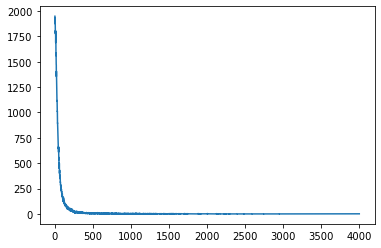

In [116]:
plt.plot(DifferenceAcc_hist[3])

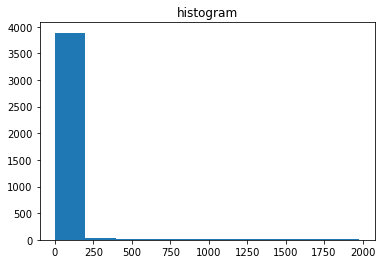

In [122]:
plt.hist(DifferenceAcc_hist[0])
plt.title("histogram")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

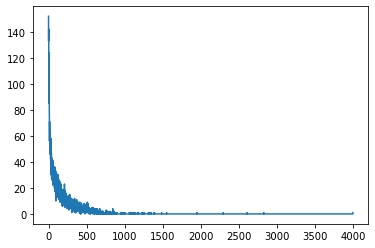

In [128]:
plt.plot(DifferenceAcc_hist[100])
plt.show

In [111]:
max(DifferenceAcc_hist[4])

4392.0

In [112]:
min(AccZ[1])

TypeError: 'float' object is not iterable

In [ ]:
for i in range(len(DifferenceAcc_list)):
  print(f"{Hz[i]}と{len(DifferenceAcc_list[i])}と{filename[i]}\n")

In [68]:
kinbou = []

for i in range(100):
    scaler = StandardScaler()
    scaler.fit(DifferenceAcc_hist)
    newdata = scaler.transform(DifferenceAcc_hist)

    x_train, x_test, y_train, y_test = train_test_split(newdata, Hz, train_size = TRAIN_SIZE, shuffle = True)

    # 学習する
    clf = KNeighborsClassifier()
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    kinbou.append(accuracy_score(y_test, y_pred))

In [69]:
mink = sum(kinbou) / len(kinbou)
print(mink)

0.3409523809523806


In [70]:
#尖度
DifferenceAcc_kurtosis = np.zeros(len(DifferenceAcc_list))
for i in range(len(DifferenceAcc_hist)):
    DifferenceAcc_kurtosis[i] = kurtosis(DifferenceAcc_hist[i])

In [71]:
#歪度
DifferenceAcc_skewness = np.zeros(len(DifferenceAcc_list))
for i in range(len(DifferenceAcc_hist)):
    DifferenceAcc_skewness[i] = skew(DifferenceAcc_hist[i])

In [72]:
#分散
histogram_var = np.zeros(len(DifferenceAcc_list))
for i in range(len(DifferenceAcc_hist)):
    histogram_var[i] = np.var(DifferenceAcc_list[i])
    #histogram_var[i] = np.var(DifferenceAcc_list[i])/len(DifferenceAcc_list[i])


In [73]:
DifferenceAcc_kurtosis

array([6.57926079e+01, 6.48225763e+01, 2.58784137e+02, 9.34657410e+01,
       1.54248019e+02, 8.09395731e+01, 2.88246971e+02, 3.77009162e+02,
       7.25970735e+01, 6.29558084e+01, 8.12569483e+01, 3.49013478e+02,
       5.15774445e+01, 6.48458705e+01, 2.00344972e+02, 4.43176606e+02,
       7.44023719e+00, 1.58423406e+01, 3.46769950e+01, 5.06286596e+01,
       5.23823940e+01, 9.65826417e+01, 8.71237485e+01, 6.94303812e+01,
       1.46093715e+02, 7.51203189e+00, 1.11431813e+02, 4.46570173e+01,
       1.02321071e+02, 1.19749769e+02, 2.29580667e+02, 1.00664737e+01,
       4.12603092e+01, 6.40332953e+01, 1.23177200e+02, 9.49731289e+01,
       2.02286665e+02, 9.83164446e+00, 1.90218026e+01, 5.81297388e+01,
       9.11320091e+01, 5.47480128e+01, 1.48220793e+02, 2.49878181e+01,
       2.15125755e+01, 5.04486318e+01, 6.53832132e+01, 5.70032643e+01,
       1.74311187e+02, 7.21896005e+01, 1.82832261e+02, 3.02328735e+02,
       5.47657492e+01, 1.08931473e+01, 7.46027290e+01, 2.48757977e+02,
      

In [74]:
DifferenceAcc_skewness

array([ 7.87615704,  7.52723461, 14.95354541,  9.26587951, 11.64261595,
        8.62596173, 15.89487234, 18.45369053,  8.17061332,  7.72880134,
        8.59598098, 17.71225195,  7.08869387,  7.64948758, 13.03714102,
       19.7380418 ,  2.97468791,  4.11377327,  5.92503739,  6.90075284,
        7.0248812 ,  9.52235549,  8.64306515,  7.93061426, 11.26660011,
        2.93191233,  9.99544253,  6.53011201,  9.17405582, 10.08316242,
       14.15095597,  3.29574055,  6.17388856,  7.77671762, 10.09656553,
        8.92879779, 13.25407645,  3.25026161,  4.23764072,  7.42361609,
        8.68937049,  7.10496697, 11.27282309,  4.77748362,  4.60263347,
        6.63493834,  7.75831598,  7.28745365, 12.27418839,  8.05399356,
       12.53584859, 16.39078498,  7.16745364,  3.37080515,  8.29696719,
       14.81380602,  6.41906919,  6.23256143,  9.44014958, 15.61564787,
        1.9117819 ,  1.64499055,  3.85490767,  4.41654414,  5.41592826,
        3.29308227,  5.42920026,  7.65778095,  9.14357827,  4.97

In [75]:
histogram_var

array([7.93053204e+15, 4.84575364e+16, 9.45944237e+16, 2.89494524e+17,
       7.46482330e+16, 4.33553387e+17, 1.79046686e+16, 5.59904623e+15,
       7.29483273e+15, 9.30644499e+15, 1.25765653e+16, 9.00768677e+15,
       3.94728075e+15, 2.67822934e+16, 2.23368926e+16, 9.51268817e+15,
       1.63945074e+15, 1.77172586e+15, 1.74967911e+15, 4.40653073e+15,
       5.41930548e+15, 1.71015166e+15, 3.81116630e+16, 2.90924690e+16,
       1.39545526e+16, 3.48645305e+15, 2.92023766e+16, 1.58921832e+15,
       3.67312680e+16, 3.05854059e+16, 1.53699257e+16, 4.32206679e+15,
       1.65423860e+16, 1.80481076e+15, 5.01081293e+16, 4.75307546e+16,
       1.73272513e+16, 6.40573222e+15, 1.55688716e+16, 2.49214573e+15,
       9.16315759e+16, 7.77139200e+16, 2.27248842e+16, 2.06558073e+16,
       1.97647454e+16, 9.84446521e+16, 2.66817174e+17, 6.06003748e+17,
       3.04520075e+17, 6.46097431e+17, 3.45415214e+16, 1.27885002e+16,
       2.03523389e+16, 3.17393256e+16, 3.21383434e+16, 1.50658412e+16,
      

In [76]:
X_new = np.concatenate((DifferenceAcc_kurtosis.reshape(-1, 1), DifferenceAcc_skewness.reshape(-1, 1), histogram_var.reshape(-1, 1)), axis=1)
X = np.concatenate((DifferenceAcc_hist, X_new), axis=1)

In [77]:
X_new[0]

array([6.57926079e+01, 7.87615704e+00, 7.93053204e+15])

In [78]:
len(X)

105

In [79]:
#ヒストグラム+尖度+歪度+分散
x_train, x_test, y_train, y_test = train_test_split(X, Hz, train_size = TRAIN_SIZE, shuffle = True)
clf = RandomForestClassifier(random_state=1234)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("正解率 = ", accuracy_score(y_test, y_pred))

正解率 =  0.5714285714285714


In [80]:
#ヒストグラム
x_train, x_test, y_train, y_test = train_test_split(DifferenceAcc_hist, Hz, train_size = TRAIN_SIZE, shuffle = True)
clf = RandomForestClassifier(random_state=1234)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("正解率 = ", accuracy_score(y_test, y_pred))

正解率 =  0.3333333333333333


In [81]:
#尖度+歪度+分散
x_train, x_test, y_train, y_test = train_test_split(X_new, Hz, train_size = TRAIN_SIZE, shuffle = True)
clf = RandomForestClassifier(random_state=1234)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("正解率 = ", accuracy_score(y_test, y_pred))

正解率 =  0.23809523809523808


In [82]:
hist_kurts = []
only_hist = []
kurtskewvar = []

for i in range(100):
    #ヒストグラム+尖度+歪度+分散
    x_train, x_test, y_train, y_test = train_test_split(X, Hz, train_size = TRAIN_SIZE, shuffle = True)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    hist_kurts.append(accuracy_score(y_test, y_pred))

    #ヒストグラム
    x_train, x_test, y_train, y_test = train_test_split(DifferenceAcc_hist, Hz, train_size = TRAIN_SIZE, shuffle = True)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    only_hist.append(accuracy_score(y_test, y_pred))

    #尖度+歪度+分散
    x_train, x_test, y_train, y_test = train_test_split(X_new, Hz, train_size = TRAIN_SIZE, shuffle = True)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    kurtskewvar.append(accuracy_score(y_test, y_pred))

In [83]:
min_hist_kurts = sum(hist_kurts) / len(hist_kurts)
min_only_hist = sum(only_hist) / len(only_hist)
min_kurtskewvar = sum(kurtskewvar) / len(kurtskewvar)
print(f"ヒスト+尖度+歪度+分散の精度：{min_hist_kurts}\nヒストグラムのみの精度:{min_only_hist}\n尖度+歪度+分散だけの精度:{min_kurtskewvar}")

ヒスト+尖度+歪度+分散の精度：0.4547619047619047
ヒストグラムのみの精度:0.4604761904761905
尖度+歪度+分散だけの精度:0.23238095238095202


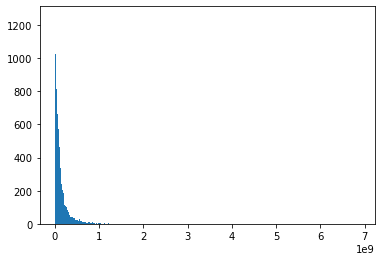

In [84]:
plt.hist(DifferenceAcc_list[13],bins=BINS)
plt.show()

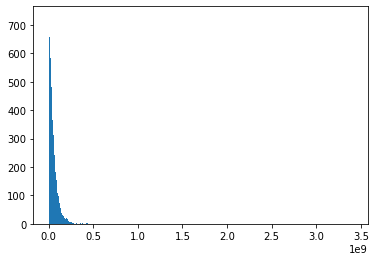

In [86]:
plt.hist(DifferenceAcc_list[20],bins=BINS)
plt.show()

In [54]:
type(DifferenceAcc_hist[0])

numpy.ndarray

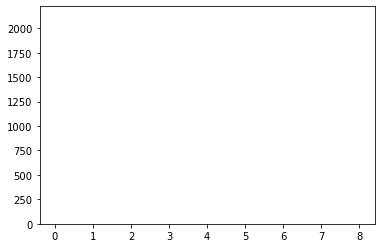

In [87]:
# Difference_histの作成
data = np.random.normal(size=4000)
Difference_hist, _ = np.histogram(data, bins=4000)

# ヒストグラムの描画
plt.hist(Difference_hist, bins=4000)
plt.show()